<h1 style="font-size: 34px; margin-bottom: 0px;">Prognoza cen akcji na kilka dni do przodu</h1>

Kto nie chciałby znać jutrzejszej ceny akcji. Na rynek akcji wpływ ma wiele czynników i prognozowanie cen w krótkim terminie jest niezwykle trudnym zadaniem.
Korzystając z danych historycznych będę starał się prognozować ceny na najbliższe dni wykorzystując modele sekwencyjne jak i modele regresji z wykorzystaniem współczynników analizy technicznej aby porównać te dwie metody.

![](graphic/01_head.jpeg)

# Import libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

#technical analysis
import ta

# pipeline
from sklearn.pipeline import Pipeline

# data processing
from sklearn.preprocessing import MinMaxScaler

# optimization and hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# models
from sklearn.linear_model import LinearRegression
import xgboost as xgb

import gradio as gr

from my_functions import load_data, plot_candle, calculate_mape
from my_functions import generate_target, predictions, gradio_test, generate_features
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
company_names = ['ibm', 'tsla', 'bp', 'wmt', 'ba', 'msft', 'nke', 'pkn', 'cdr', 'pko']
my_df = pd.DataFrame()

for i, company_name in enumerate(company_names):
    df = load_data(company_name)
    df['Company'] = company_name.upper()    
    my_df = pd.concat([my_df, df], axis=0)

my_df.sort_values(by=['Date', 'Company'], inplace=True)
column_sorted = ['Date', 'Company'] + [col for col in my_df.columns if col not in ['Date', 'Company']]
my_df = my_df[column_sorted]
my_df.reset_index(drop=True, inplace=True)
    
my_df

,Date,Company,Open,High,Low,Close,Volume
0,1962-01-02,IBM,5.04610,5.04610,4.98716,4.98716,5.935630e+05
1,1962-01-03,IBM,4.98716,5.03292,4.98716,5.03292,4.451750e+05
2,1962-01-04,IBM,5.03292,5.03292,4.98052,4.98052,3.995136e+05
3,1962-01-05,IBM,4.97389,4.97389,4.87511,4.88166,5.593215e+05
4,1962-01-08,IBM,4.88166,4.88166,4.75059,4.78972,8.332738e+05
...,...,...,...,...,...,...,...
86257,2023-08-22,NKE,100.96000,102.37000,100.76500,100.83000,4.257859e+06
86258,2023-08-22,PKN,64.27000,65.17000,63.95000,64.31000,1.596261e+06
86259,2023-08-22,PKO,37.22000,37.33000,36.61000,36.71000,1.480884e+06
86260,2023-08-22,TSLA,240.25000,240.82000,229.55000,232.70000,8.479278e+07


In [109]:
# my_df['Target'] = my_df.groupby('Company')['Close'].apply(lambda x: (x - x.shift(1)))

# Exploratory Data Analysis

                                            Wybrane spółki:

| Nazwa:                | Ticker:    | Branża:                      |
|-----------------------|------------|------------------------------|
| INT BUSINESS MACHINES | IBM        | Technologie informacyjne     |
| Tesla                 | TSLA       | Produkcja Samochodów         |
| BP                    | BP         | Energetyczna                 |
| Walmart Inc           | WMT        | Sprzedaż detaliczna i hurtowa|
| Boeing Co             | BA         | Lotnictwo                    |
| Microsoft Corp        | MSFT       | Technologie informacyjne     |
| NIKE Inc              | NKE        | Obuwie i akcesoria           |
| PKN ORLEN SA          | PKN        | Energetyczna                 |
| CD Projekt SA         | CDR        | Elektroniczna rozrywka       |
| PKO Bank Polski SA    | PKO        | Finanse                      |

In [3]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86262 entries, 0 to 86261
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     86262 non-null  datetime64[ns]
 1   Company  86262 non-null  object        
 2   Open     86262 non-null  float64       
 3   High     86262 non-null  float64       
 4   Low      86262 non-null  float64       
 5   Close    86262 non-null  float64       
 6   Volume   86262 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 4.6+ MB


Czy są wartości brakujące?

In [4]:
my_df.loc[my_df.isnull().any(axis=1)]

,Date,Company,Open,High,Low,Close,Volume


Jaki jest udział poszczególnych spółek w zbiorze?

In [5]:
my_df['Company'].value_counts()

IBM     15511
BA      13526
WMT     12895
MSFT     9435
NKE      9072
CDR      7218
PKN      5942
PKO      4701
BP       4653
TSLA     3309
Name: Company, dtype: int64

Wykresy świecowe wraz z wolumenem

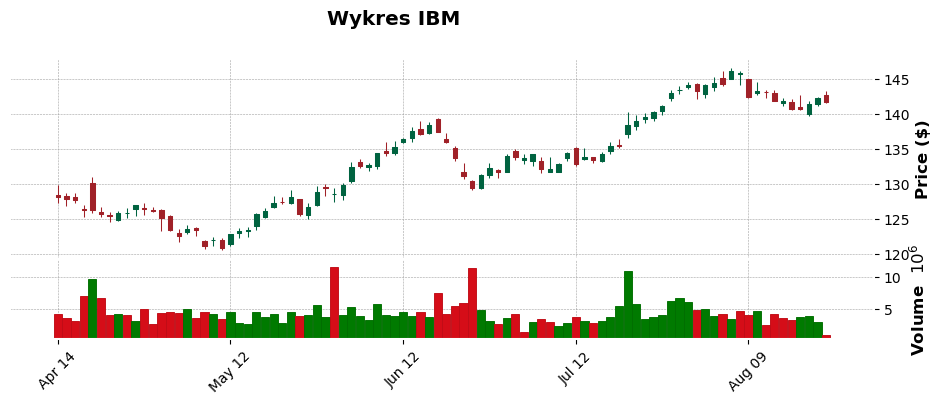

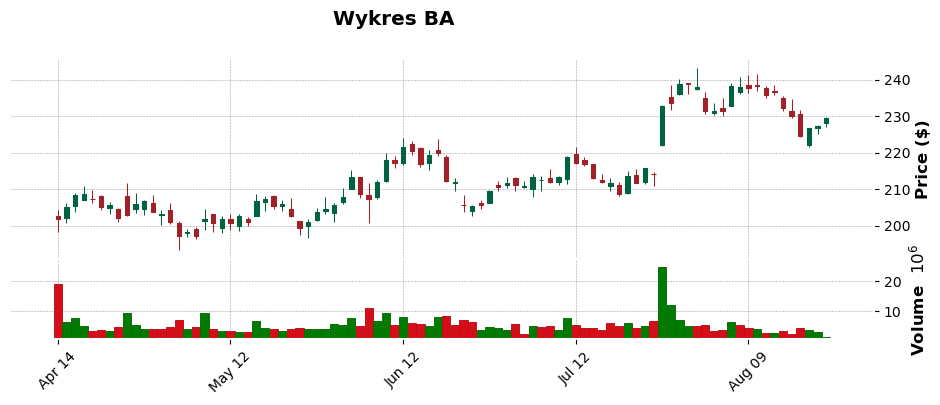

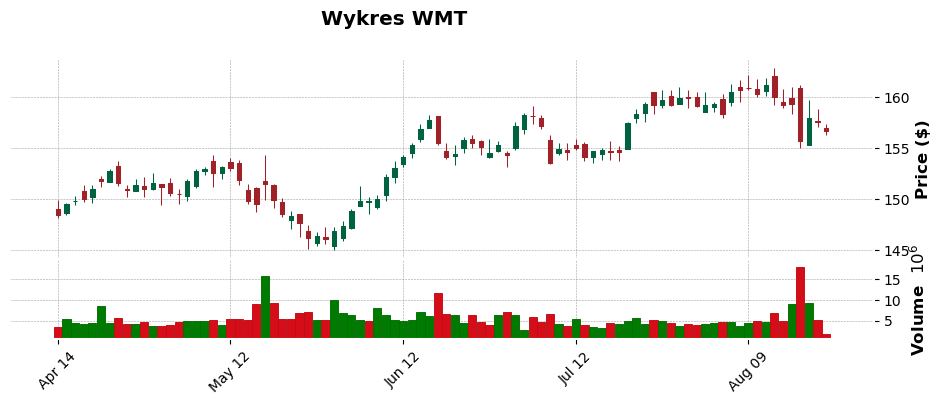

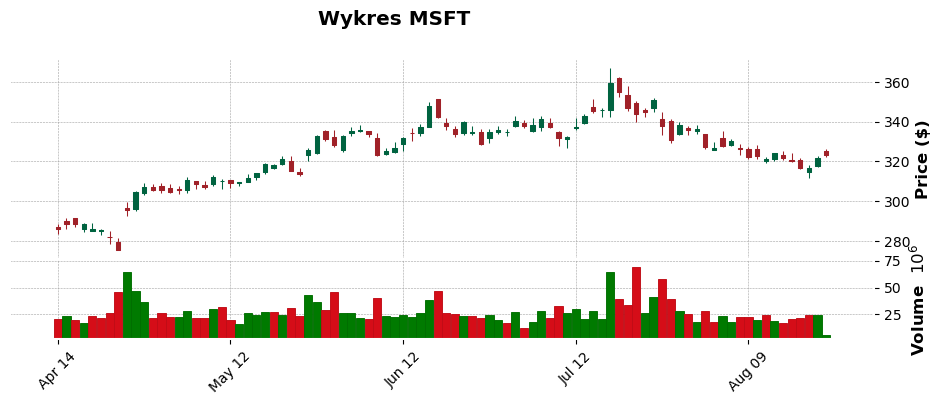

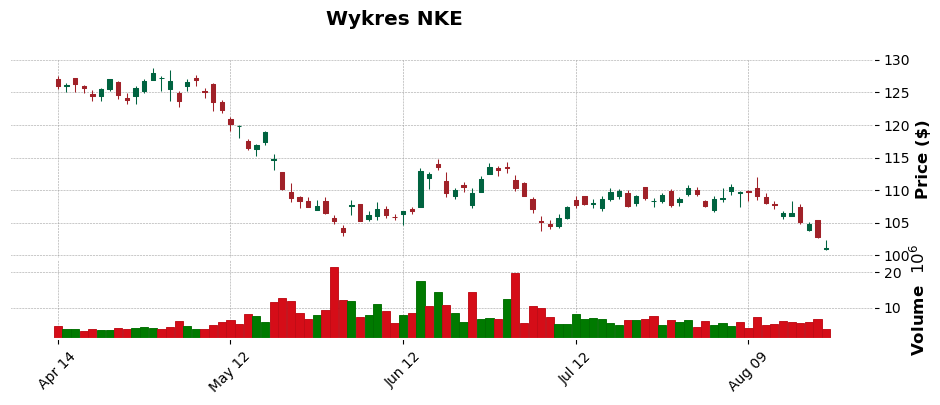

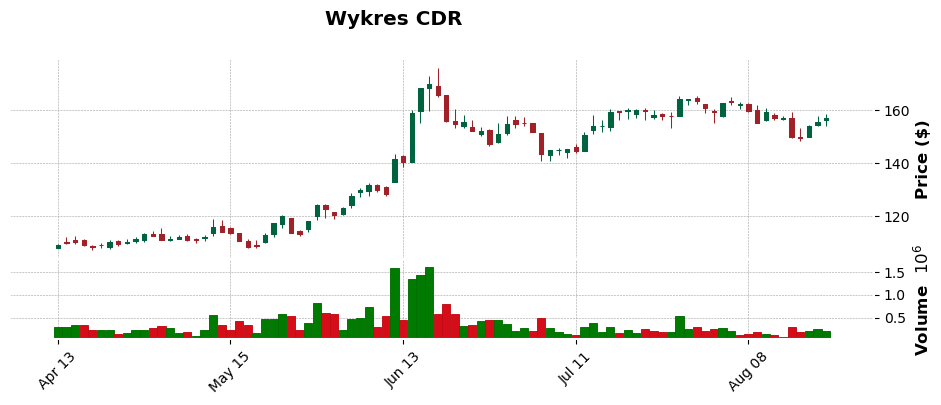

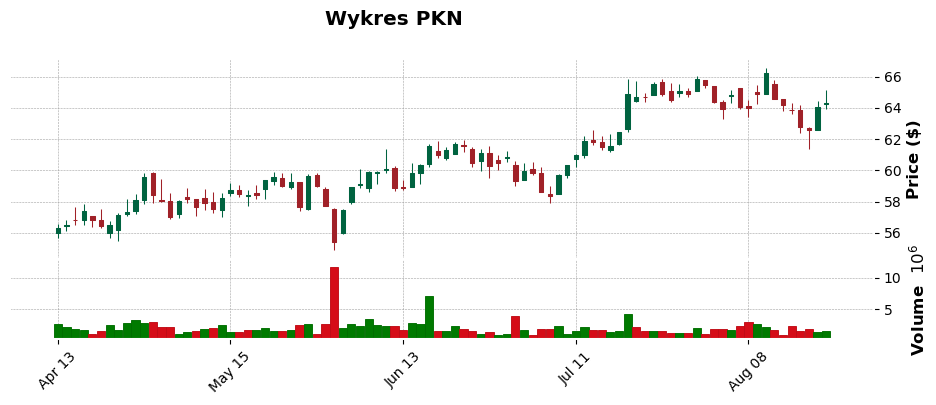

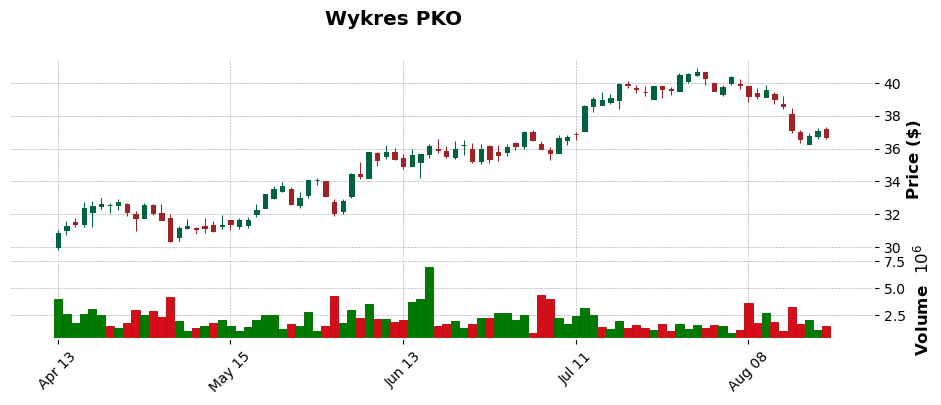

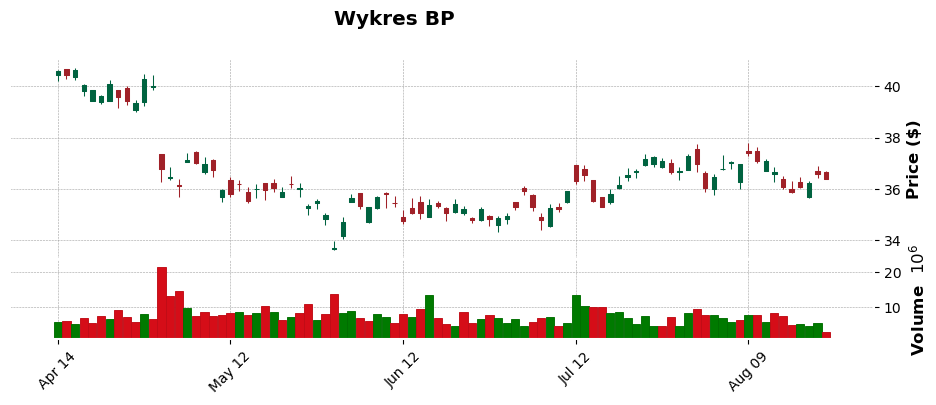

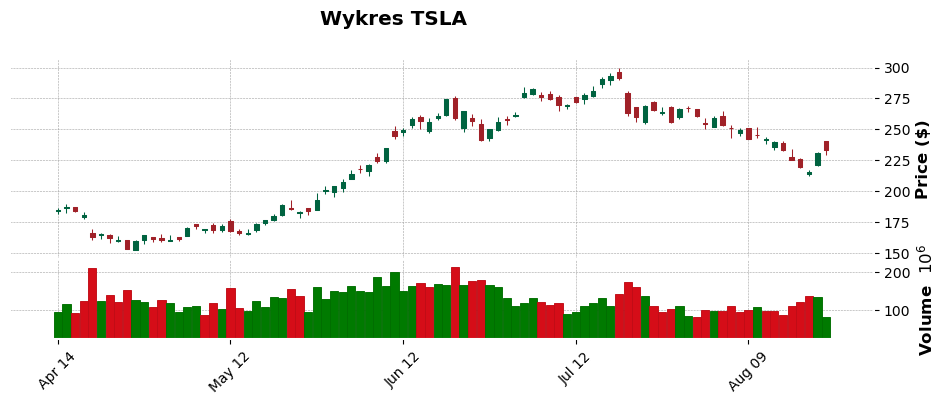

In [6]:
for name in my_df['Company'].unique():
    plot_candle(my_df, name, 90, figsize = (12, 4))

# Baseline Model
Do modelu podstawowego będę porównywał moje modele. Założeniem mojego modelu będzie to, że cena jutrzejsza nie zmieni się w stosunku do ceny dzisiejszej.

In [7]:
base_df = my_df

In [8]:
base_df['Close_predict'] = base_df.groupby('Company')['Close'].apply(lambda x: x.shift(-1))
base_df

,Date,Company,Open,High,Low,Close,Volume,Close_predict
0,1962-01-02,IBM,5.04610,5.04610,4.98716,4.98716,5.935630e+05,5.03292
1,1962-01-03,IBM,4.98716,5.03292,4.98716,5.03292,4.451750e+05,4.98052
2,1962-01-04,IBM,5.03292,5.03292,4.98052,4.98052,3.995136e+05,4.88166
3,1962-01-05,IBM,4.97389,4.97389,4.87511,4.88166,5.593215e+05,4.78972
4,1962-01-08,IBM,4.88166,4.88166,4.75059,4.78972,8.332738e+05,4.84867
...,...,...,...,...,...,...,...,...
86257,2023-08-22,NKE,100.96000,102.37000,100.77000,101.08890,4.093862e+06,NaN
86258,2023-08-22,PKN,64.27000,65.17000,63.95000,64.31000,1.596261e+06,NaN
86259,2023-08-22,PKO,37.22000,37.33000,36.61000,36.71000,1.480884e+06,NaN
86260,2023-08-22,TSLA,240.25000,240.82000,229.55000,232.98000,8.270214e+07,NaN


Mój zbiór treningowy zawiera dane od 2023-01-01 do 2023-07-31

In [9]:
base_df_test = base_df[(base_df['Date'] >= '2023-01-01') & (base_df['Date'] <= '2023-07-31')]
base_df_test.shape

(1443, 8)

In [10]:
calculate_mape(base_df_test['Close_predict'], base_df_test['Close'])

1.391776293528869

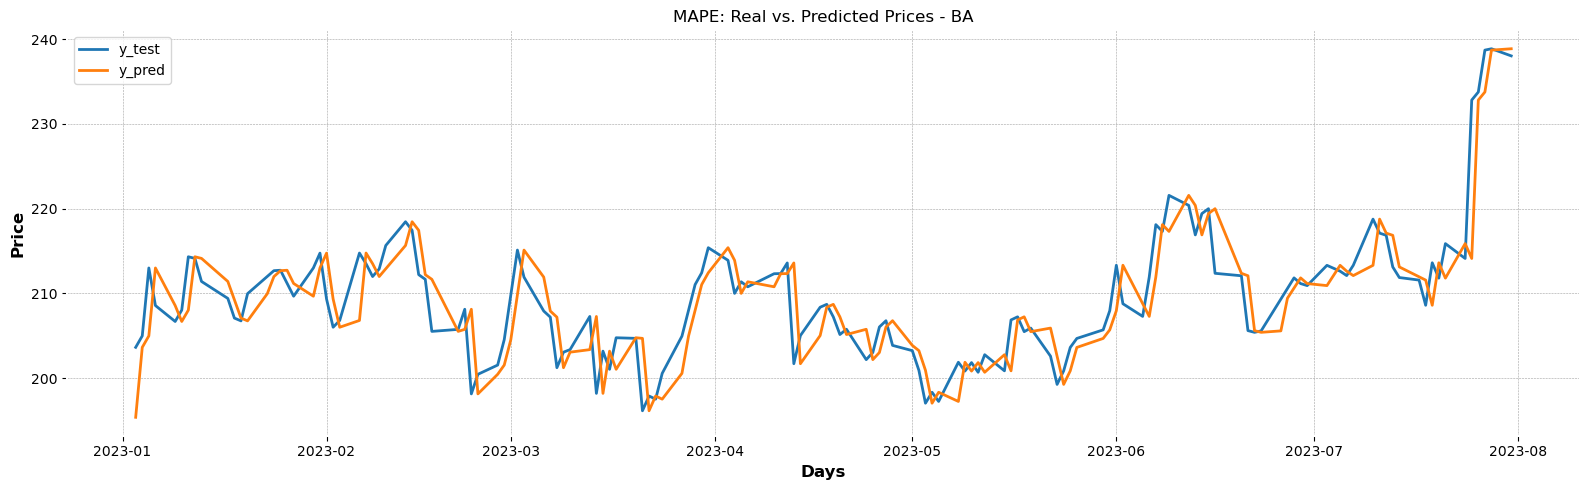

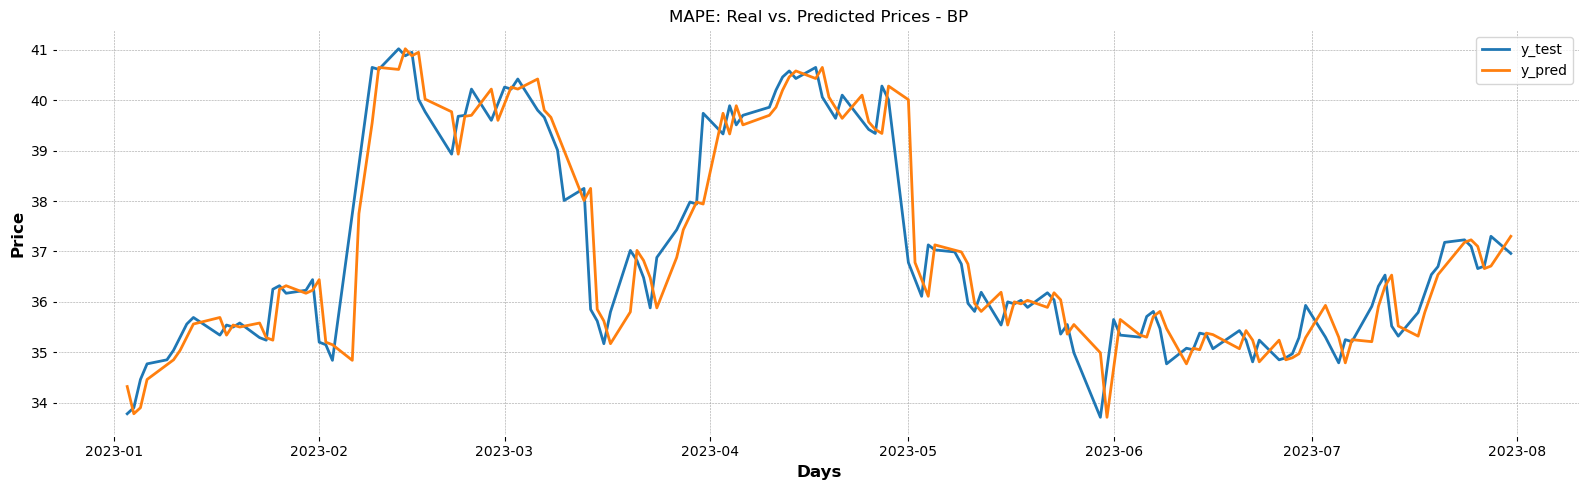

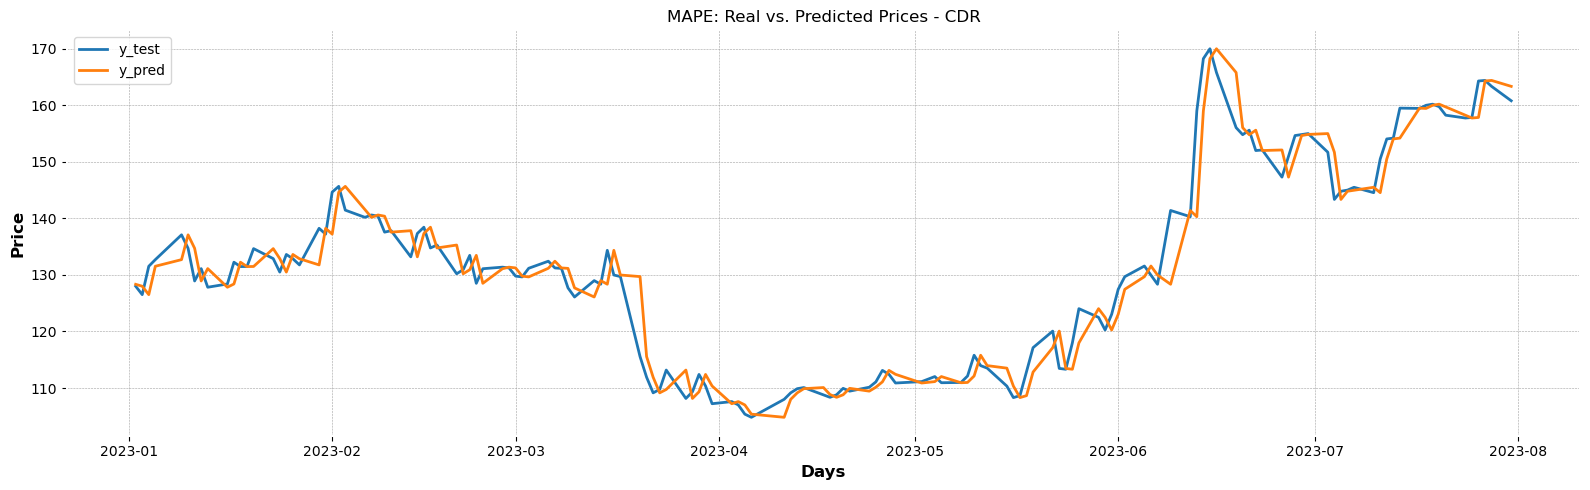

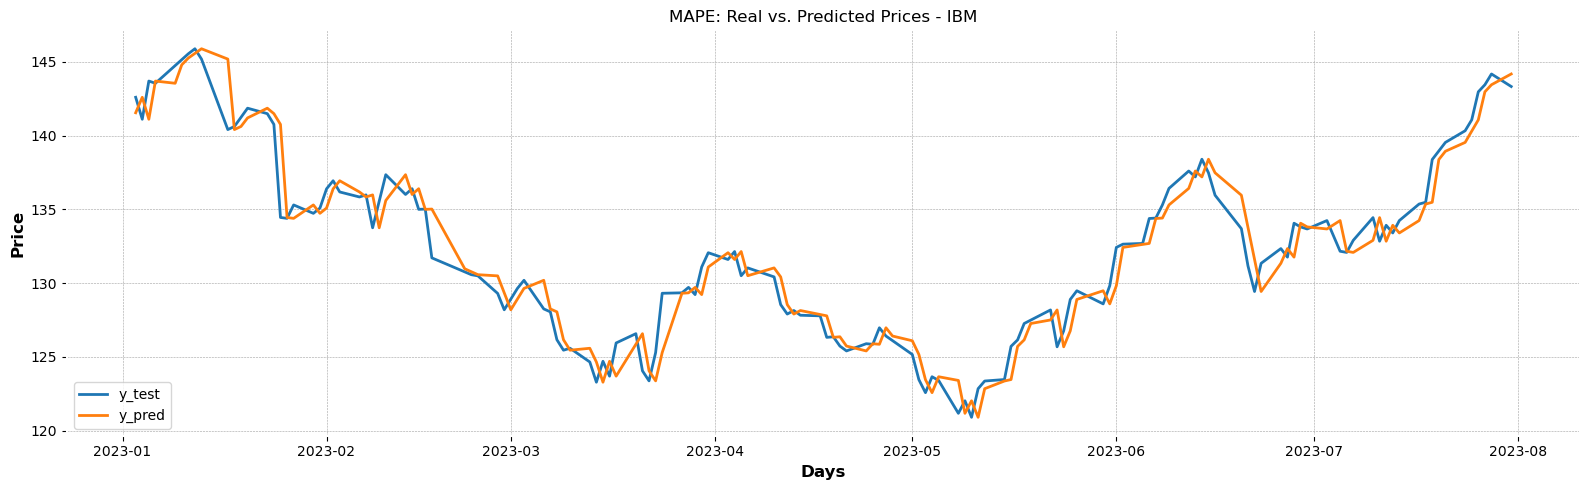

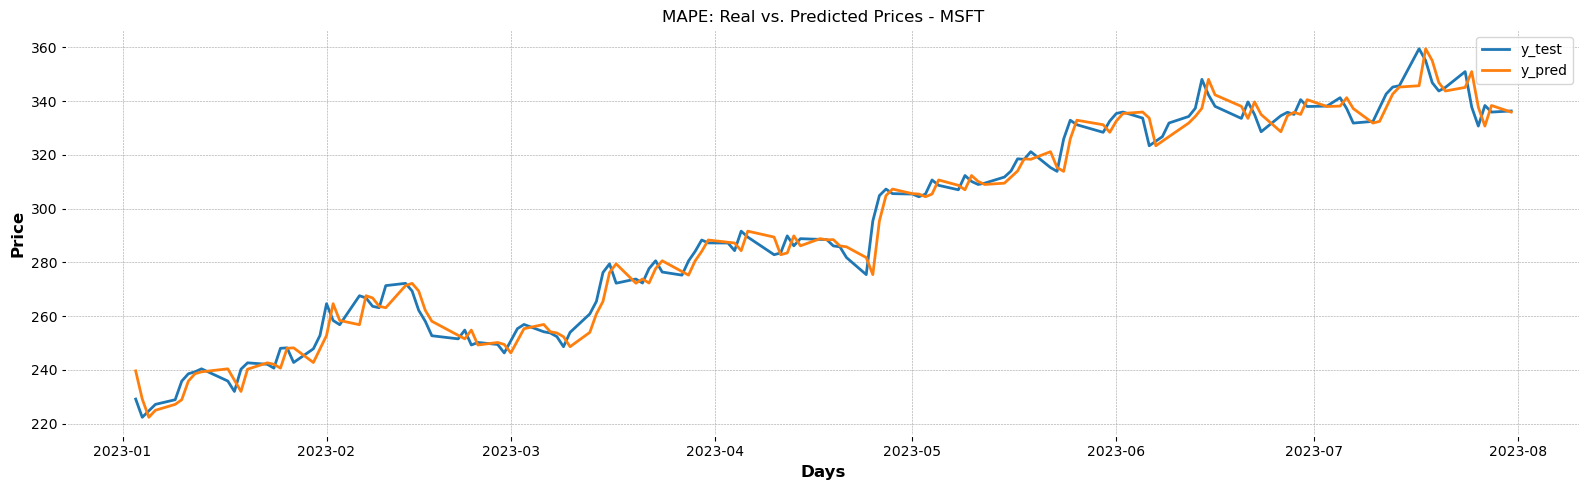

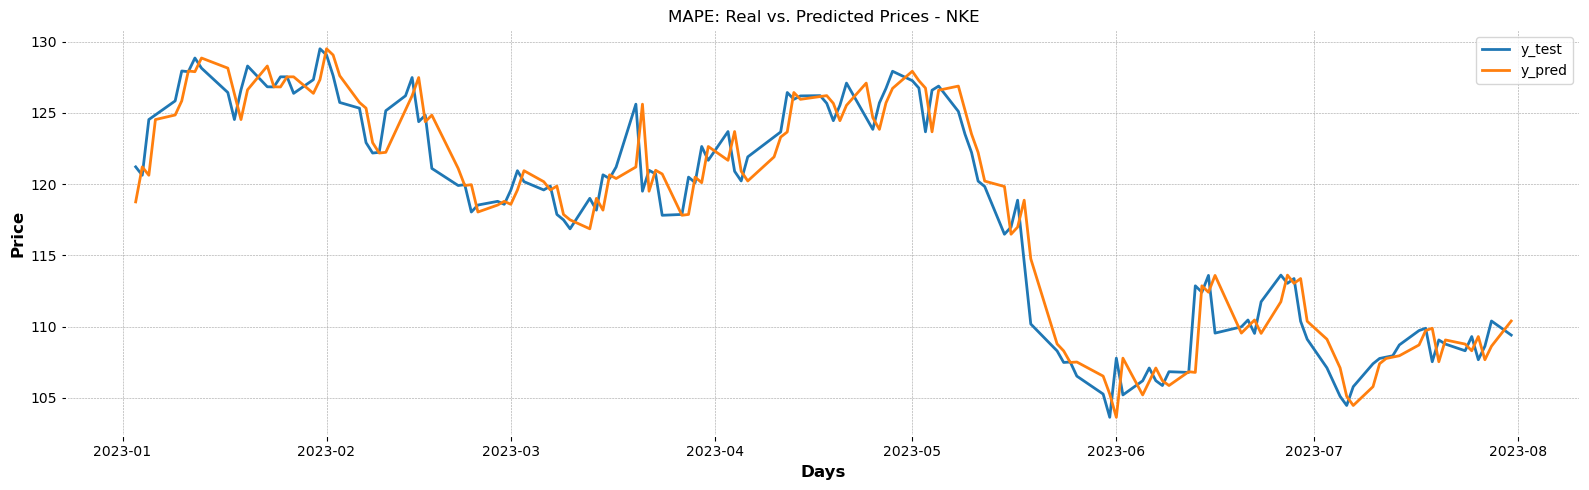

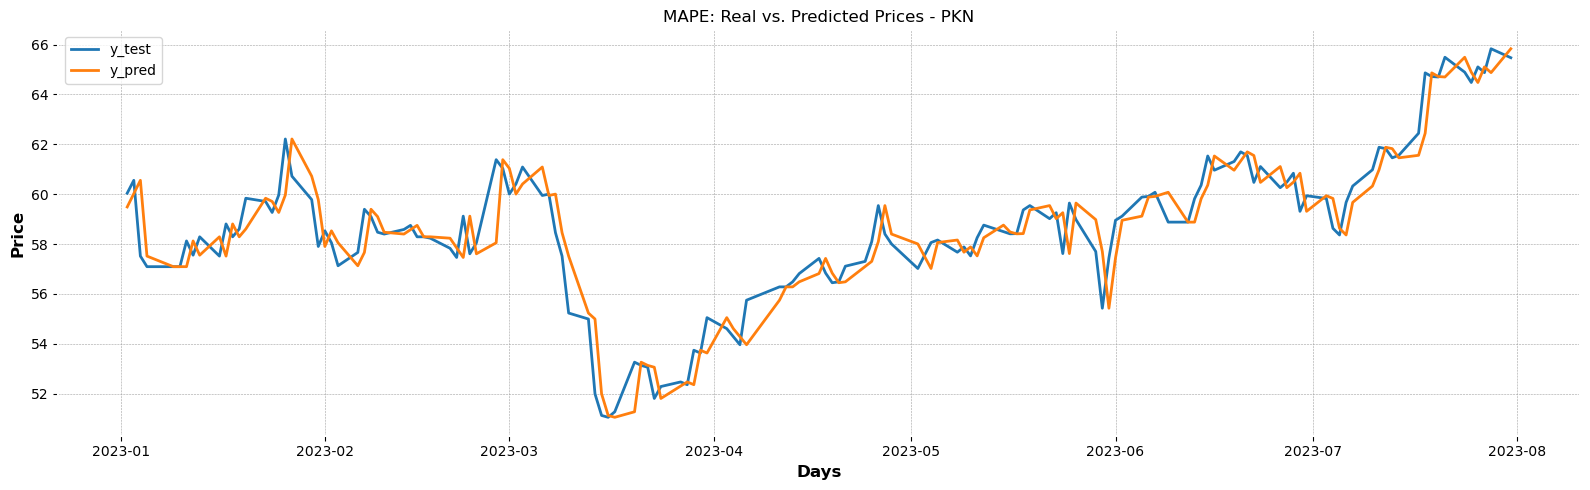

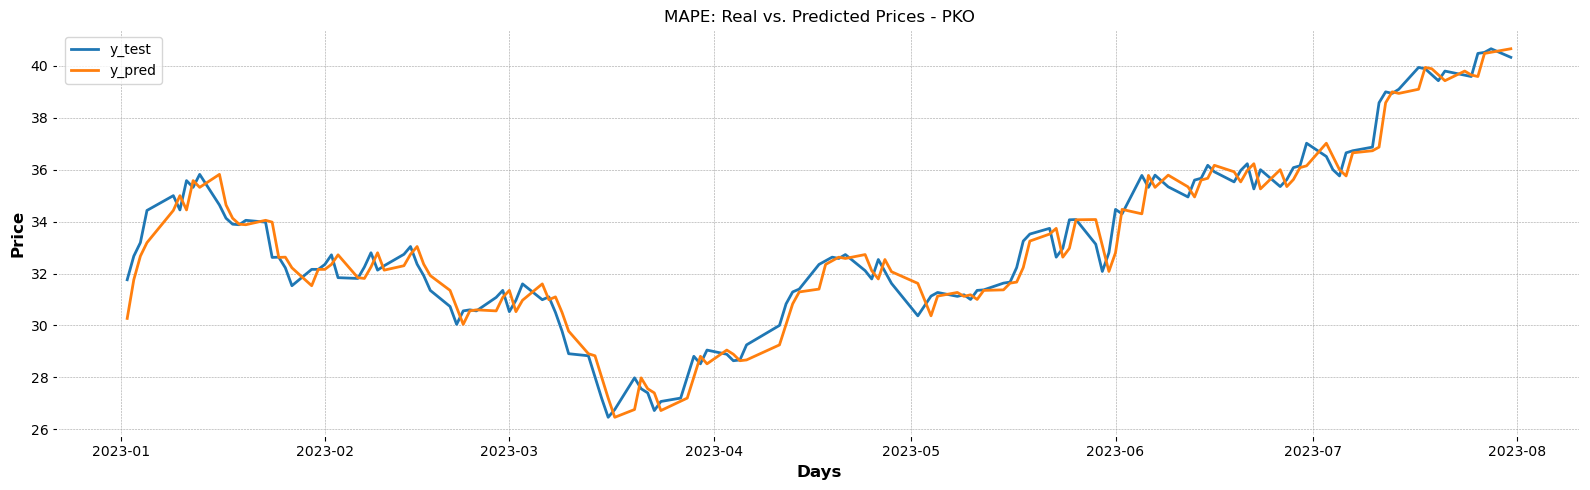

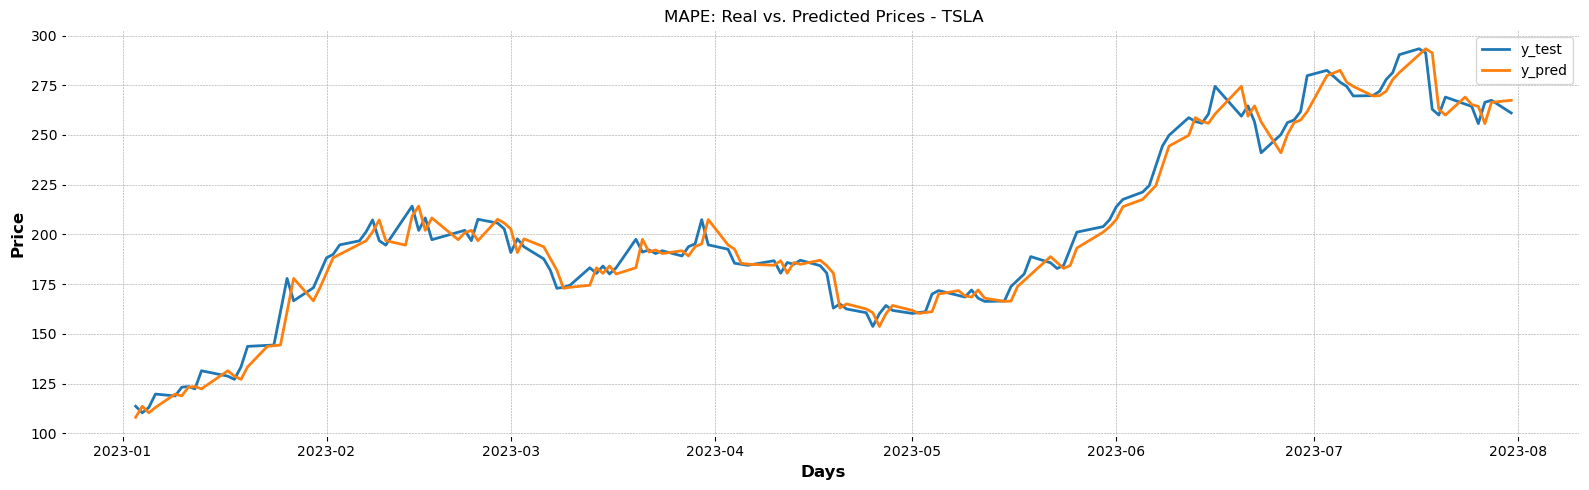

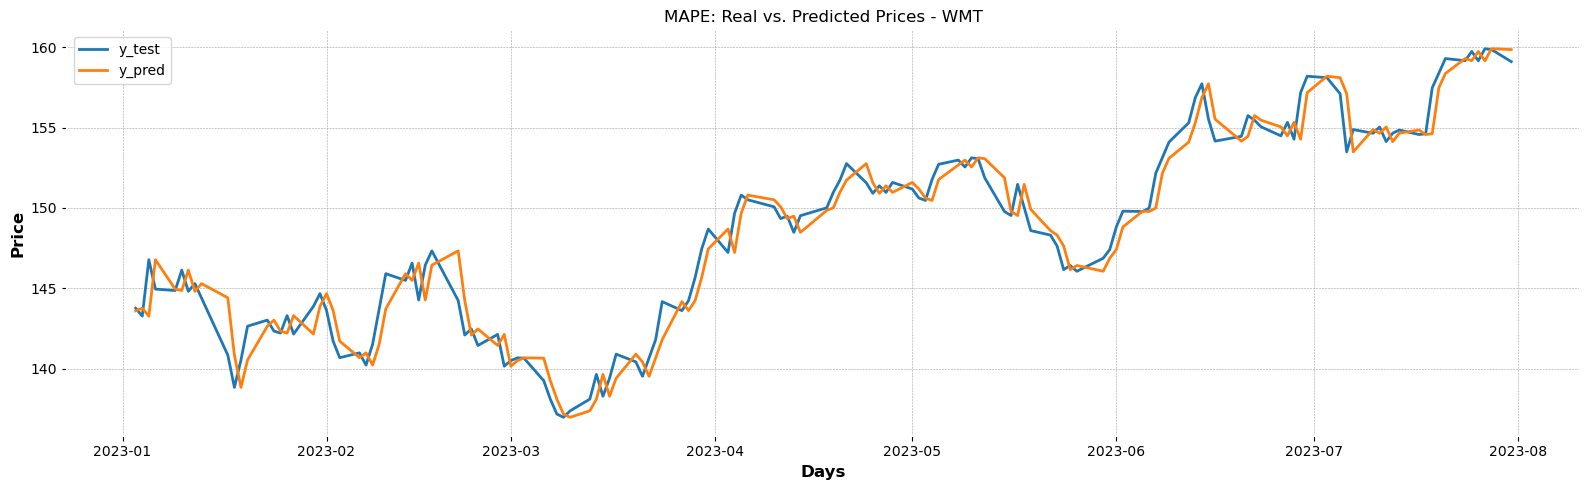

In [11]:
grouped = base_df_test.groupby('Company')

for name, group in grouped:
    plt.figure(figsize=(16, 5))
    plt.plot(group['Date'], group['Close_predict'], label='y_test')
    plt.plot(group['Date'], group['Close'], label='y_pred')
    plt.legend()

    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'MAPE: Real vs. Predicted Prices - {name}')
    plt.tight_layout()
    plt.show()

# Data Preprocessing - Feature Engineering

Utworzone cechy:
- Close_diff - zmiana ceny zamknięcia,
- Close_diff_perc - procentowa zmiana ceny zamknięcia,
- Open_diff - zmiana ceny otwarcia,
- Open_diff_perc - procentowa zmiana ceny otwarcia,
- Volume_1w - średni wolumen z ostatniego tygodnia,
- Volume_2w - średni wolumen z ostatnich 2 tygodni,
- Volume_1m - średni wolumen z ostatniego miesiąca,
- Ratio_volume_1w_2w - stosunek średnich wolumenów z ostatniego tygodnia i ostatnich 2 tygodni,
- Ratio_volume_1w_1m - stosunek średnich wolumenów z ostatniego tygodnia i ostatnego miesiąca,
- Std_price_1w - odchylenie standardowe cen zamknięcia z ostatniego tygodnia,
- Std_price_1m - odchylenie standardowe cen zamknięcia z ostatniego miesiąca,
- Ratio_std_price_1w_1m - stosunek Std_price_1w do Std_price_1m,
- Std_volume_1w - odchylenie standardowe wolumenów z ostatniego tygodnia,
- Std_volume_1m - odchylenie standardowe wolumenów z ostatniego miesiąca,
- Ratio_std_volume_1w_1m - stosunek Std_volume_1w do Std_volume_1m,
- Return_1d - zwrot z ostatniego dnia,
- Return_1w - zwrot z ostatniego tygodnia,
- Return_1m - zwrot z ostatniego miesiąca,
- Moving_avg_1w - średni zwrot z ostatniego tygodnia,
- Moving_avg_1m - średni zwrot z ostatniego miesiąca,
- SMA_5 - średnia krocząca cen zamknięcia dla ostatniego tygodnia,
- SMA_10 - średnia krocząca cen zamknięcia dla ostatnich 2 tygodni,
- SMA_30 - średnia krocząca cen zamknięcia dla ostatniego miesiąca,
- EMA_10 - wykładnicza średnia krocząca dla ostatnich 10 dni cen zamknięcia,
- EMA_20 - wykładnicza średnia krocząca dla ostatnich 20 dni cen zamknięcia,
- MACD - linia MACD, która jest różnicą między dwiema wykładniczymi średnimi kroczącymi (12 i 26 dni),
- MACD_diff - różnica między MACD a jego sygnałem,
- MACD_signal - linia sygnału MACD,
- BOLL_high - górny pas Bollingera,
- BOLL_low - dolny pas Bollingera,
- BOLL_perc - procent pasma Bollingera,
- ROC_10 - wskaźnik szybkości zmiany na podstawie ostatnich 10 dni cen zamknięcia,
- ROC_20 - wskaźnik szybkości zmiany na podstawie ostatnich 20 dni cen zamknięcia,
- MI - wskaźnik masy, który mierzy zmienność cen,
- OBV - wolumen zrównoważony, który pomaga ocenić przepływ kapitału do lub z akcji,
- NVI - wskaźnik negatywnego wolumenu, który pomaga śledzić trendy na rynku na podstawie zmian wolumenu,
- ADX - średni wskaźnik kierunkowy, który pomaga ocenić siłę trendu na rynku,
- CMF - przepływ kapitału Chaikina, który pomaga ocenić przepływ kapitału w relacji do cen,
- PVO - oscylator procentowy wolumenu,
- PVO_hist - to różnica między dwiema wartościami PVO (zwykle krótszym i dłuższym okresem),
- PVO_signal - sygnał wygładzany za pomocą średniej kroczącej, służący do identyfikacji trendów w zmienności wolumenu,
- UO - oscylator ostateczny, który pomaga śledzić trzy różne okresy,
- DPO - oscylator cen pozbawiony trendu.

Podzielę zbiór na treningowy i testowy. Testowy będą to tak samo jak w modelu bazowym dane od 2023-01-01 do 2023-07-31.

In [3]:
X_train, y_train, X_test, y_test = generate_target(my_df, days_to_forecast = 5, first_test_day = '2023-01-01', last_test_day = '2023-07-31')

Generating Date Features: 100%|████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (83641, 37)
y_train shape: (83641, 5)
X_test shape: (1443, 37)
y_test shape: (1443, 5)


# Feature extraction

## Feature correlation

In [112]:
corr_matrix = X_train.corr()

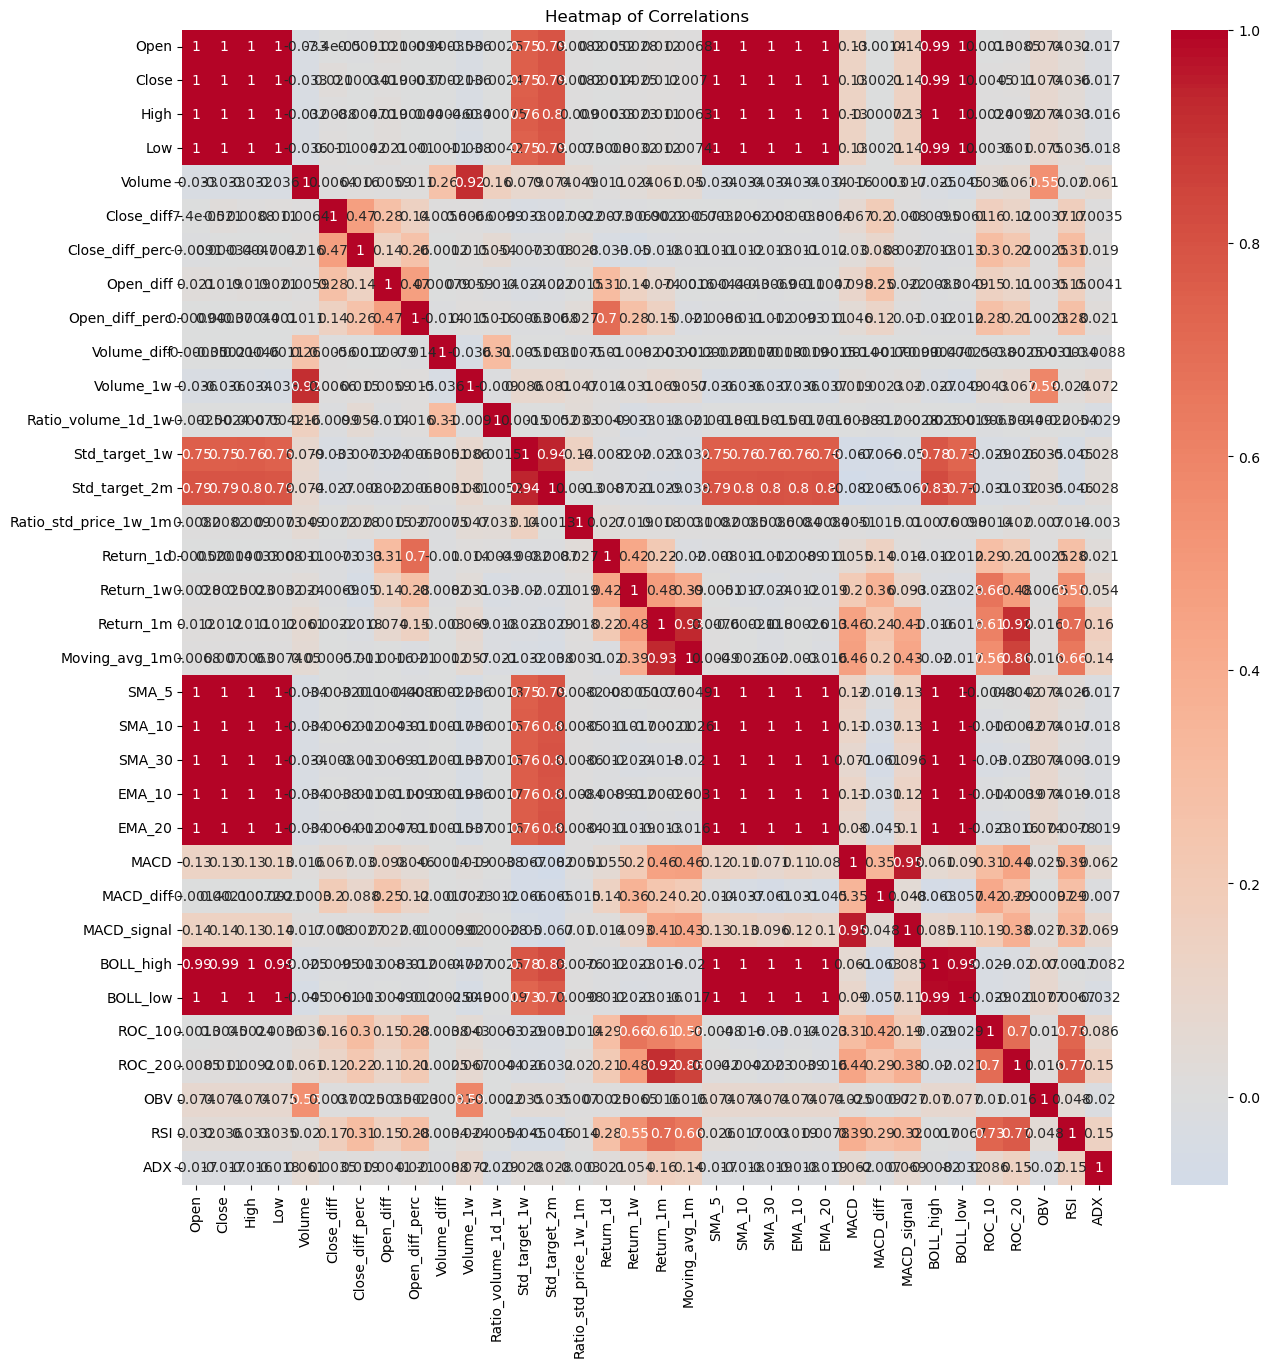

In [113]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlations')
plt.show()

## Backward elimination

In [96]:
import statsmodels.api as sm

X_abc = X_train.iloc[:,2:]

model_stats = sm.OLS(y_train[:,0], X_abc).fit()

while model_stats.pvalues.max() > 0.05:
    feature_to_remove = model_stats.pvalues.idxmax()
    X_abc = X_abc.drop(columns=[feature_to_remove])
    model_stats = sm.OLS(y_train[:,0], X_abc).fit()

print(model_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 22 Aug 2023   Prob (F-statistic):                nan
Time:                        18:56:31   Log-Likelihood:                    nan
No. Observations:               83218   AIC:                               nan
Df Residuals:                   83185   BIC:                               nan
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Open                         n

# Models

## LinearRegression

In [5]:
pipeline_lr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('linear_regression', LinearRegression())
])

pipeline_lr.fit(X_train.iloc[:,2:], y_train)

y_pred_lr = pipeline_lr.predict(X_test.iloc[:,2:])


MAPE dla prognozy jednodniowej

In [6]:
calculate_mape(y_pred_lr[:,0], y_test[:,0])

3.217879478473339

MAPE dla prognozy 5-dniowej

In [7]:
calculate_mape(y_pred_lr, y_test)

3.8410446239316665

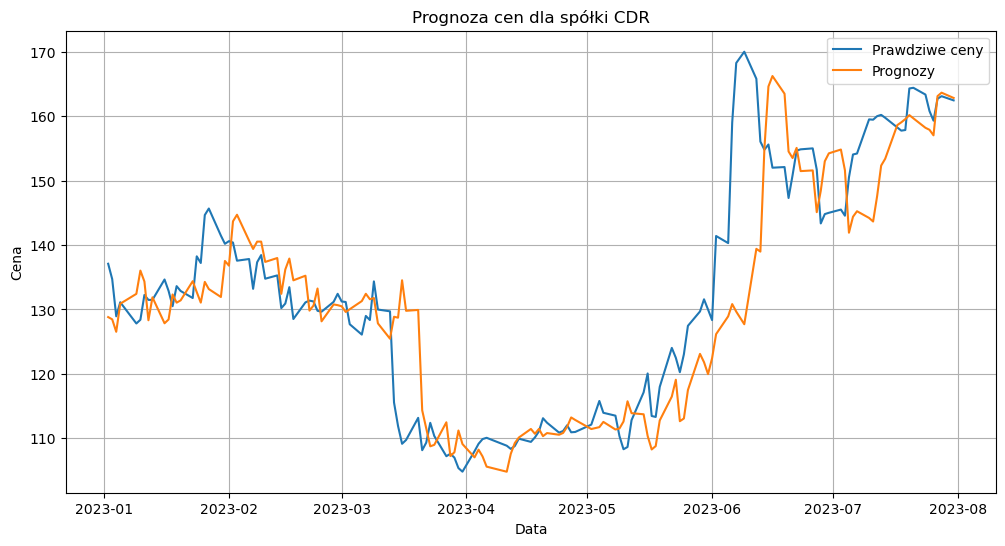

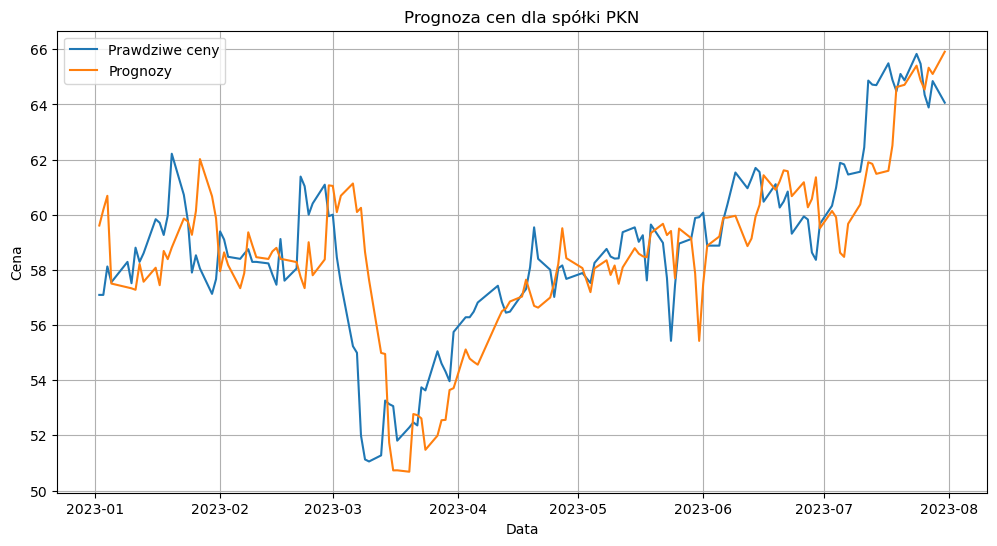

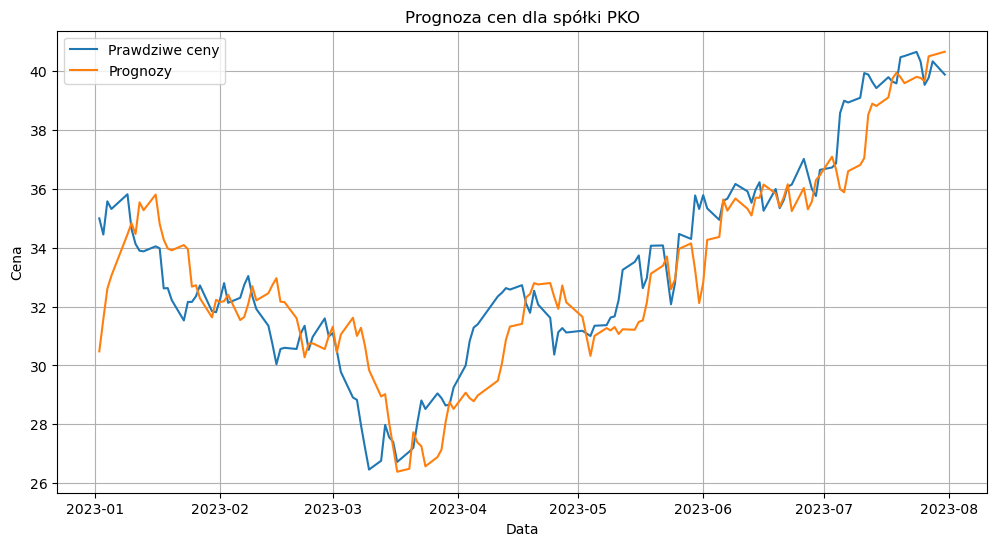

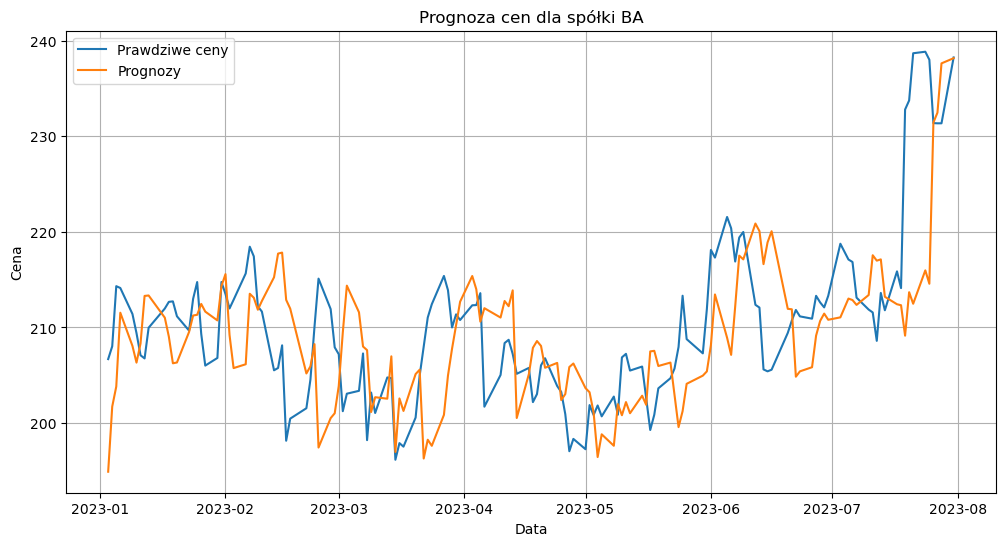

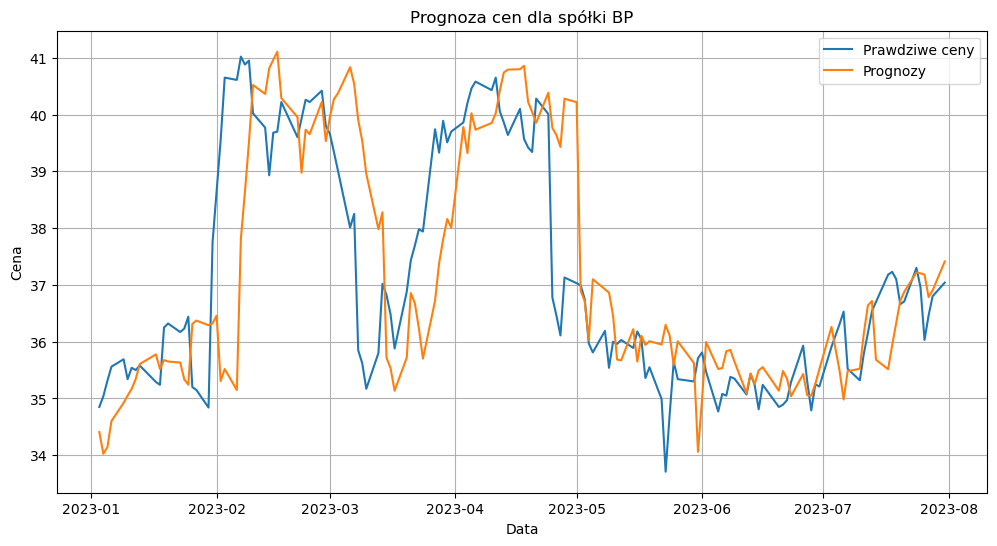

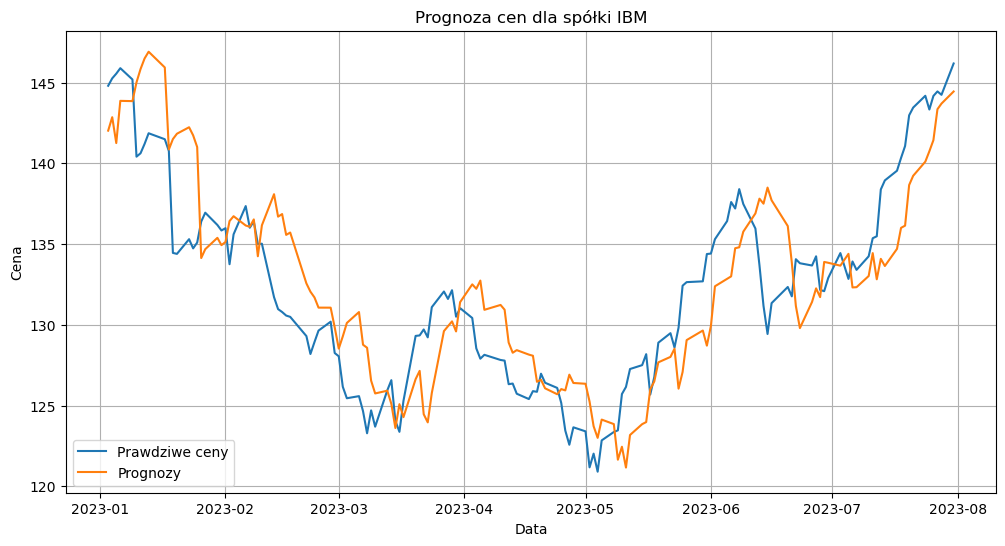

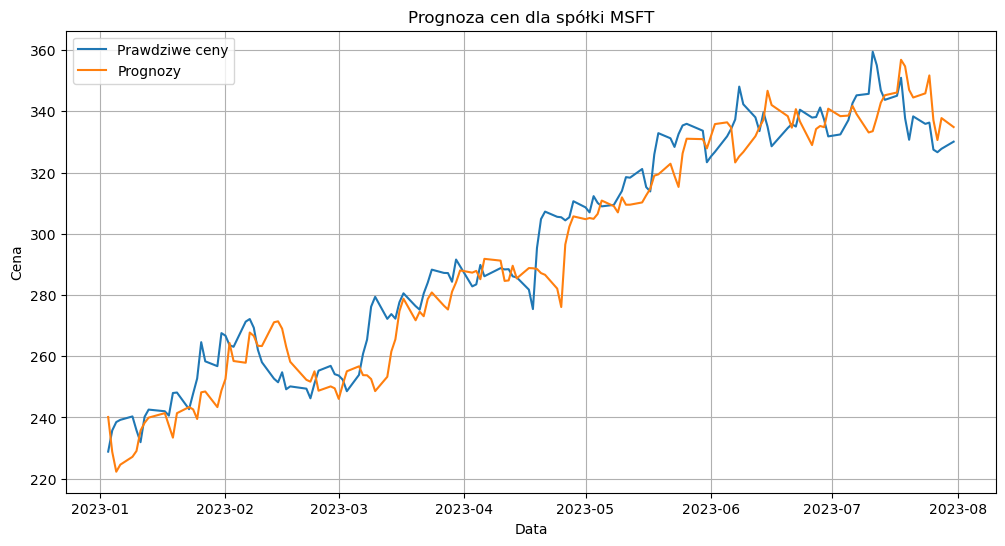

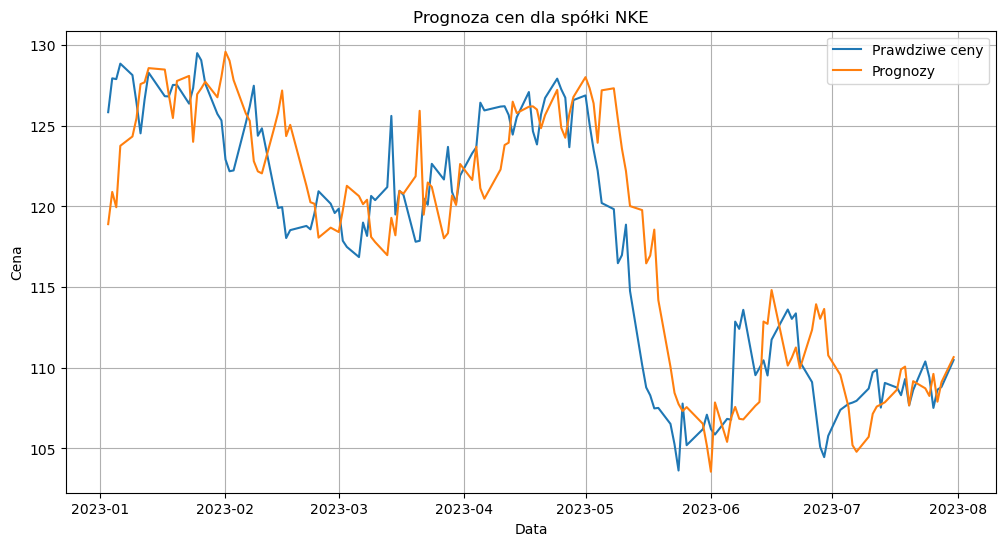

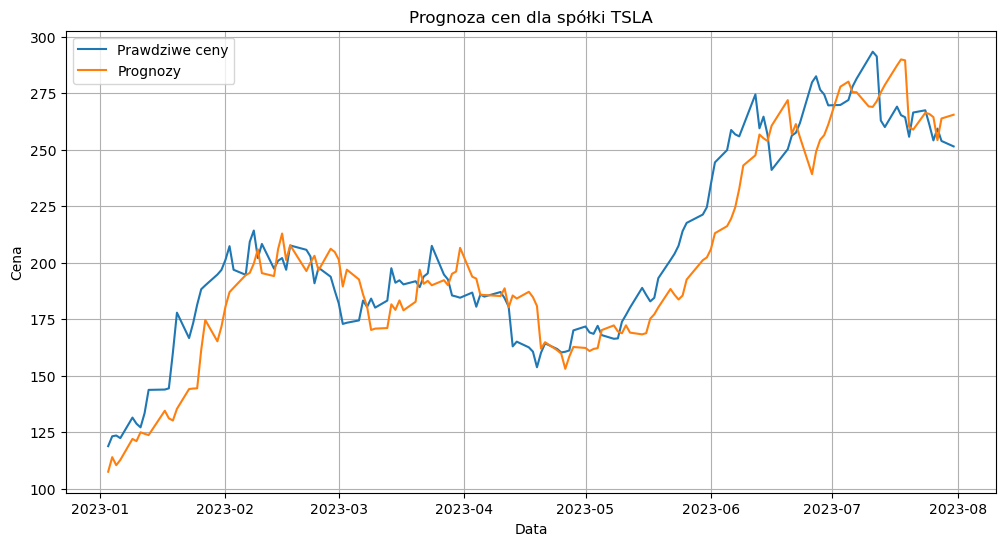

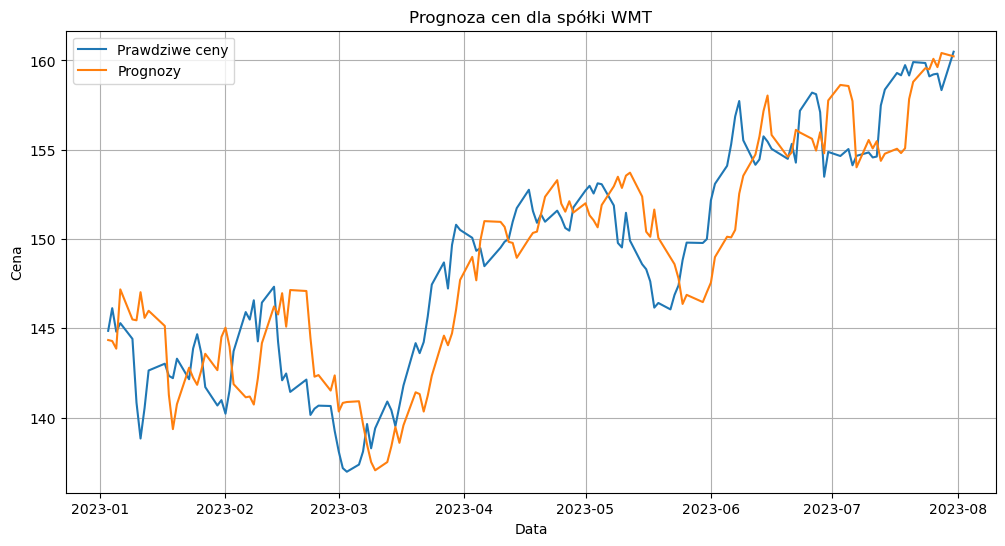

In [26]:
for company in X_test['Company'].unique():
    company_indices = X_test['Company'] == company
    company_dates = X_test['Date'][company_indices]
    company_y_true = y_test[company_indices]
    company_y_pred = y_pred_lr[company_indices]
    
    plt.figure(figsize=(12, 6))
    plt.plot(company_dates, company_y_true[:,0], label='Prawdziwe ceny')
    plt.plot(company_dates, company_y_pred[:,0], label='Prognozy')
    plt.title(f'Prognoza cen dla spółki {company}')
    plt.xlabel('Data')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid()
    plt.show()

## Model XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_absolute_percentage_error',
    cv=3,
    n_jobs=-1,
    random_state=42
)

pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('random_search', random_search)
])

pipeline_xgb.fit(X_train.iloc[:,2:], y_train)

In [ ]:
print("Najlepsze parametry:")
print(pipeline.named_steps['random_search'].best_params_)

In [124]:
pipeline_xgb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('xgbregressor', xgb.XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.3))
])

pipeline_xgb.fit(X_train.iloc[:,2:], y_train)

y_pred_Xgb = pipeline_xgb.predict(X_test.iloc[:,2:])

MAPE dla prognozy jednodniowej

In [129]:
calculate_mape(y_pred_Xgb[0], y_test[0])

4.701015067199131

MAPE dla prognozy 5-dnodniowej

In [128]:
calculate_mape(y_pred_Xgb, y_test)

4.628550424332486

In [11]:
xgb_model = xgb.XGBRegressor(max_depth=6, n_estimators=200, learning_rate=0.2)
xgb_model.fit(X_train.iloc[:,2:], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [12]:
y_pred_Xgb = xgb_model.predict(X_test.iloc[:,2:])

In [13]:
calculate_mape(y_pred_Xgb[0], y_test[0])

8.965191188438707

# Predictions

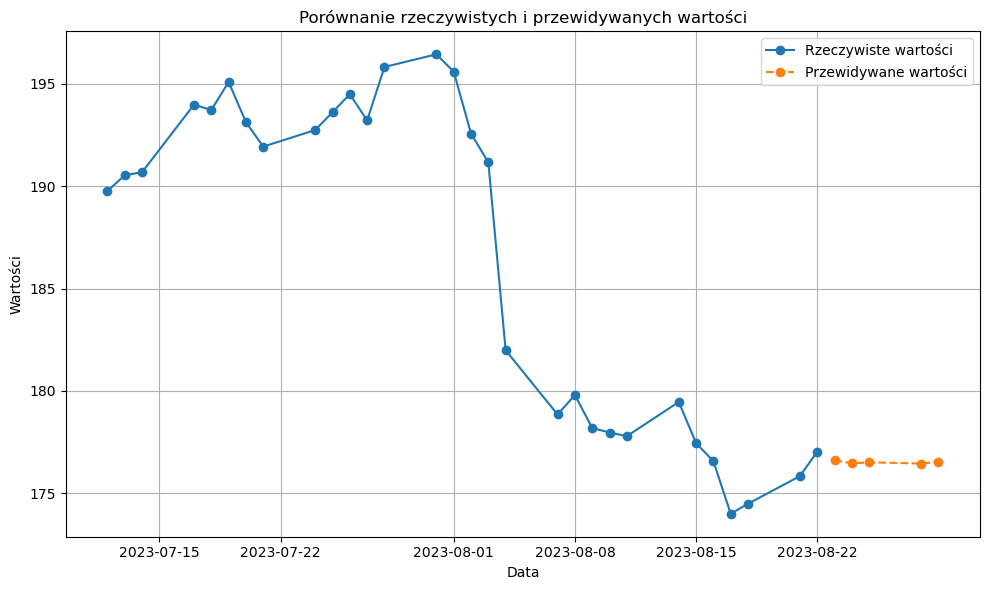

In [14]:
predictions('aapl', pipeline_lr)

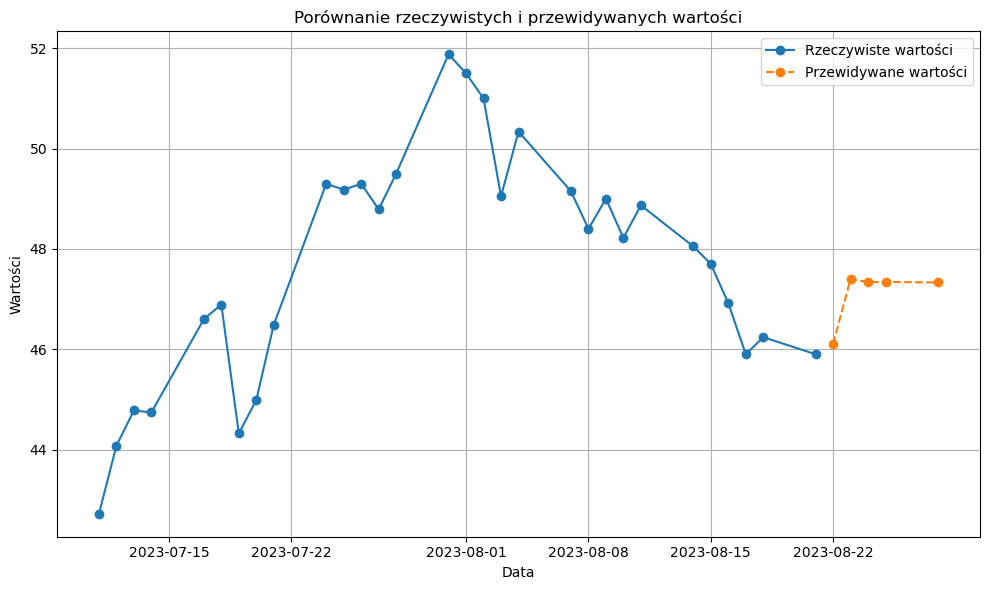

In [15]:
predictions('ccc', xgb_model)

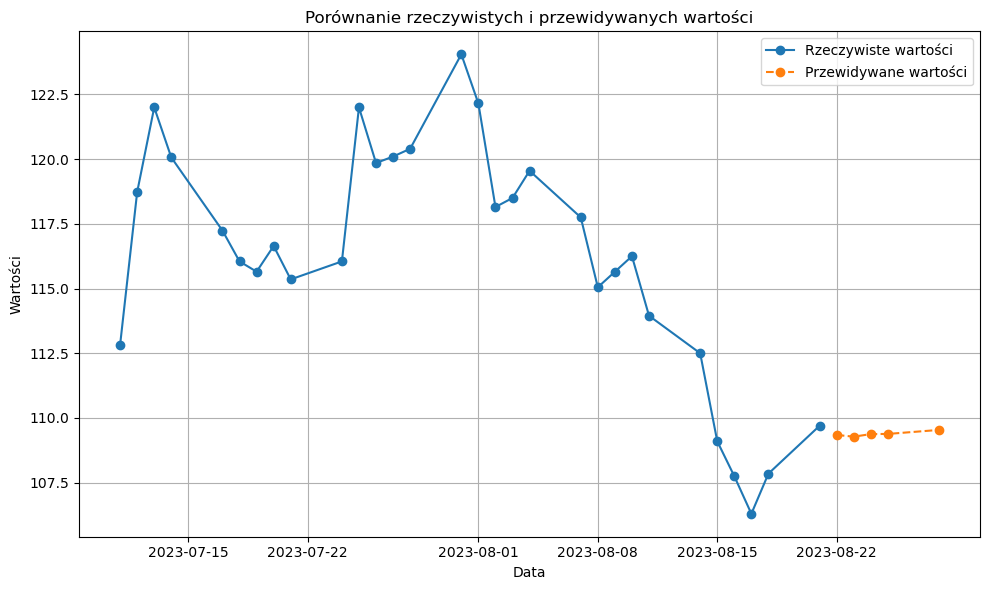

In [16]:
predictions('kgh', pipeline_lr)

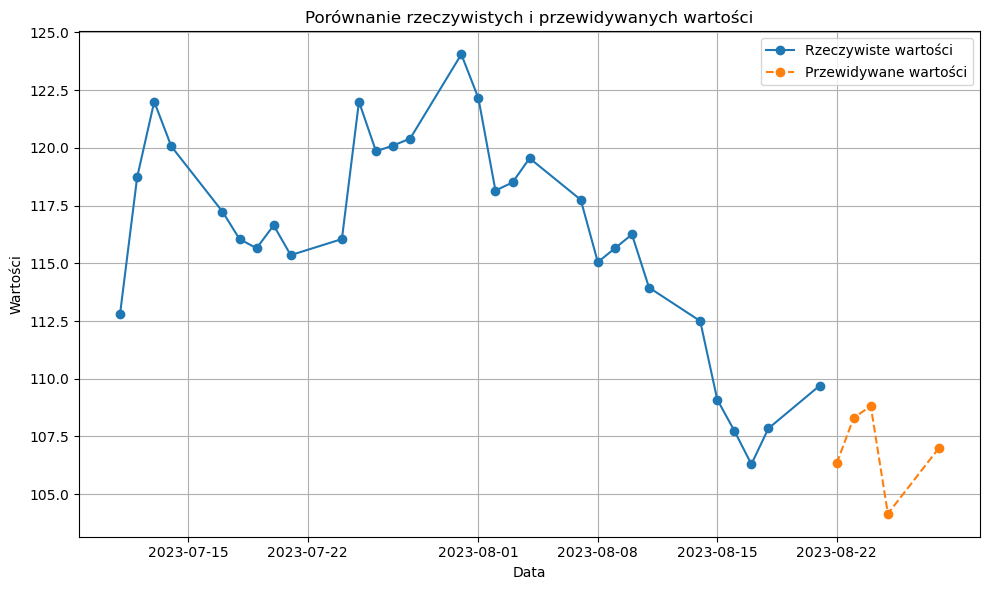

In [17]:
predictions('kgh', xgb_model)

In [20]:
def gradio_generator(company_name: str):
    company_name = company_name
    df = load_data(company_name)
    df['Company'] = company_name.upper()
    df = generate_features(df)
    df = df.iloc[-30:]
    y_pred = xgb_model.predict(df.iloc[:,2:])
    
    y_true = df['Close']
    y_pred = y_pred[-1]
    
    start_date = pd.to_datetime(df['Date'].iloc[0])
    dates_pred = pd.date_range(start=start_date, periods=(len(y_true) + len(y_pred)), freq='B')

    y_true = np.concatenate([y_true.values, [np.nan] * len(y_pred)])

    plt.figure(figsize=(10, 6))
    plt.plot(dates_pred, y_true, label='Rzeczywiste wartości', marker='o')
    plt.plot(dates_pred[-len(y_pred):], y_pred, label='Przewidywane wartości', marker='o', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Wartości')
    plt.title('Porównanie rzeczywistych i przewidywanych wartości')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    return plt

In [21]:
iface = gr.Interface(
    fn=gradio_generator,
    inputs=gr.inputs.Textbox(label="Nazwa spółki", type="text"),
    outputs="plot",
    live=False  # Ustaw `live` na `False`, aby pokazać wykres po przesłaniu danych
)

In [22]:
iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
